In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
# for reprot and visualization and find the best threshold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
with open ("../datasets/ICF/icf_level123_def.txt",'r',encoding='utf-8') as infile:
    raw_level123_def = infile.read()

level123_def = raw_level123_def.split('.')
print('num of train sentences:', len(level123_def))

num of train sentences: 320


In [3]:
df_test = pd.read_csv('../datasets/test set/full_test_sep.tsv', sep='\t')
df_icf = pd.read_csv('../datasets/ICF/ICF_def_label.tsv', sep='\t')

icf_def = df_icf['def'][:-1].tolist()
labels = df_icf['label'].tolist()
sentence = df_test['utterances'].tolist()

# transform label to num
df_test.loc[df_test['gold'] == 'learning', 'gold'] = 0
df_test.loc[df_test['gold'] == 'general', 'gold'] = 1
df_test.loc[df_test['gold'] == 'communication', 'gold'] = 2
df_test.loc[df_test['gold'] == 'mobility', 'gold'] = 3
df_test.loc[df_test['gold'] == 'selfcare', 'gold'] = 4
df_test.loc[df_test['gold'] == 'domestic', 'gold'] = 5
df_test.loc[df_test['gold'] == 'interpersonal', 'gold'] = 6
df_test.loc[df_test['gold'] == 'major', 'gold'] = 7
df_test.loc[df_test['gold'] == 'social', 'gold'] = 8
df_test.loc[df_test['gold'] == 'none', 'gold'] = 9

checklabel = [0,1,2,3,4,5,6,7,8,9]
gold = df_test['gold'].tolist()
for n,i in enumerate(gold):
    if i not in checklabel:
        if i != '-'*20:
            print(i,n)
print('clean labels')

clean labels


In [4]:
if '-'*20 in sentence:
    print('with sep processing')
    sentence = [ i for i in sentence if i != '-'*20]

if '-'*20 in gold:
    print('with sep processing')
    gold = [ i for i in gold if i != '-'*20]

with sep processing
with sep processing


In [5]:
print('num of def:', len(icf_def))
print('num of label:', len(labels))
print('num of test sentences:', len(sentence))

num of def: 9
num of label: 10
num of test sentences: 583


In [6]:
model_name = 'stsb-mpnet-base-v2'
model_trained = SentenceTransformer(model_name)

In [7]:
sentence_emb_1 = model_trained.encode(sentence)
sentence_emb_2 = model_trained.encode(icf_def)
all_cos_score = cosine_similarity(sentence_emb_1, sentence_emb_2)
print('score dimension:', all_cos_score.shape)

score dimension: (583, 9)


In [8]:
# all_cos_score = all_cos_score.tolist()
max_cos = ["%.2f" % np.max(all_cos_score, axis = None)]
max_score_each_row = ["%.3f" % n for n in np.amax(all_cos_score, axis = 1)]
max_score_each_row = [float(n) for n in max_score_each_row]
max_score_ind = np.argmax(all_cos_score, axis =1)
print(len(max_score_each_row) == len(max_score_ind))
print('max cos:', max_cos)
print('max cos of each row:', 'total rows:', len(max_score_each_row))
print(max_score_each_row)
print('-'*20)
print('max cos index of each row:', 'total rows:', len(max_score_ind))
print(max_score_ind)
# max_score, max_score_ind

True
max cos: ['0.59']
max cos of each row: total rows: 583
[0.225, 0.211, 0.109, 0.19, 0.246, 0.283, 0.323, 0.22, 0.137, 0.082, 0.167, 0.137, 0.253, 0.28, 0.167, 0.33, 0.189, 0.285, 0.283, 0.275, 0.213, 0.178, 0.182, 0.157, 0.234, 0.266, 0.128, 0.217, 0.16, 0.256, 0.233, 0.256, 0.234, 0.257, 0.25, 0.18, 0.188, 0.204, 0.22, 0.205, 0.155, 0.382, 0.177, 0.289, 0.329, 0.279, 0.296, 0.389, 0.159, 0.486, 0.323, 0.309, 0.303, 0.308, 0.238, 0.321, 0.312, 0.294, 0.487, 0.237, 0.503, 0.559, 0.476, 0.399, 0.368, 0.579, 0.468, 0.142, 0.44, 0.194, 0.161, 0.206, 0.059, 0.162, 0.232, 0.2, 0.179, 0.196, 0.139, 0.213, 0.164, 0.247, 0.165, 0.186, 0.11, 0.213, 0.112, 0.19, 0.088, 0.21, 0.174, 0.251, 0.226, 0.201, 0.34, 0.437, 0.412, 0.35, 0.301, 0.284, 0.338, 0.139, 0.132, 0.375, 0.151, 0.155, 0.214, 0.241, 0.132, 0.319, 0.085, 0.38, 0.297, 0.207, 0.299, 0.26, 0.006, 0.312, 0.309, 0.146, 0.216, 0.147, 0.108, 0.252, 0.177, 0.198, 0.228, 0.114, 0.125, 0.338, 0.094, 0.252, 0.231, 0.208, 0.043, 0.255, 0.325

In [9]:
m = max(max_score_ind)
m # the ind list only has 0-8 which are the real category, then we put 9 as index for 'none' in the following section

8

In [10]:
zip_scor_ind = list(zip(max_score_each_row, max_score_ind))

def get_predictions(zip_scor_ind, threshold):
    """"""
    # threshold = 0.10
    predictions = []
    for s, i in zip_scor_ind:
        if s >= threshold:
            predictions.append(i)
        elif s < threshold:
            predictions.append(9) # index 9 means 'none'
        else:
            print('error comparison')
    return predictions

def get_best_fscore(thresholdlist, zip_scor_ind, gold):
    """"""
    list_fscore = []
    for threshold in thresholdlist:
        predictions = get_predictions(zip_scor_ind, threshold)
        list_fscore.append(f1_score(gold, predictions,average='macro'))
    max_fsc = max(list_fscore)
    best_thres = thresholdlist[list_fscore.index(max(list_fscore))]
    return(max_fsc, best_thres)

# predictions = get_predictions(zip_scor_ind, threshold=0.1)
thresholdlist = [0.1,0.2,0.3,0.4,0.5,0.53,0.6,0.75,0.8]
max_fsc, best_thres = get_best_fscore(thresholdlist, zip_scor_ind, gold)
print('threshold list:',thresholdlist)
print('max-macro fscore:', '%.3f' % max_fsc)
print('best threshold',best_thres)


threshold list: [0.1, 0.2, 0.3, 0.4, 0.5, 0.53, 0.6, 0.75, 0.8]
max-macro fscore: 0.392
best threshold 0.2


In [11]:
# get classification report 
# model_name = './output/tsdae-bert-base-uncased-icf-model'
print(model_name)
predictions = get_predictions(zip_scor_ind, best_thres)
confusion = confusion_matrix(gold, predictions)
report = classification_report(gold, predictions)

print(report)

stsb-mpnet-base-v2
              precision    recall  f1-score   support

           0       0.38      0.56      0.45        27
           1       0.26      0.36      0.30        33
           2       0.43      0.72      0.54        18
           3       0.29      0.27      0.28        45
           4       0.38      0.39      0.38        31
           5       0.79      0.62      0.70        77
           6       0.65      0.30      0.41        67
           7       0.50      0.14      0.22        35
           8       0.30      0.11      0.16        57
           9       0.42      0.59      0.49       193

    accuracy                           0.44       583
   macro avg       0.44      0.41      0.39       583
weighted avg       0.46      0.44      0.42       583



In [12]:
for i, label in enumerate(labels):
    print(i,label)

0 learning 
1 general 
2 communication
3 mobility
4 selfcare 
5 domestic 
6 interpersonal 
7 major
8 social
9 none 


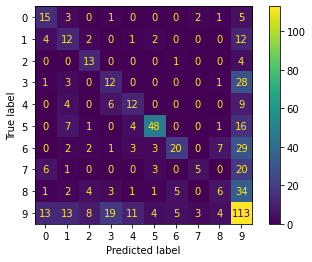

In [13]:
# plot confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=checklabel)
disp.plot()
plt.show()

In [14]:
model = model_name.split('/')[-1]
df_predictions = pd.DataFrame({
    'utterances':sentence,
    'predictions':predictions
    })
df_predictions.to_csv(f'../datasets/predictions/predictions_{model}_level_1.tsv', sep='\t',index=None)